In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torchvision
import torch
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import data_util
from model_interpretation import viz

def plot(data, labels, s=3, figsize=(7,6)):
    plt.figure(figsize=figsize)
    plt.scatter(*data.T, s=s, c=labels, cmap='tab10')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

def get_prob(estimator, data, idx):
    '''Equivalent to estimator.predict_proba(data[idx:idx+1])'''

    logits = (estimator.coef_@data[idx:idx+1].T).T + estimator.intercept_
    probs_calc = scipy.special.softmax(logits)
    return probs_calc

def cross_entropy(estimator, data, labels):
    """Calculate the cross-entropy."""
    logs = estimator.predict_log_proba(data)
    logs_c = -logs[range(len(logs)), labels]

    return logs_c.mean()

# Folder to save the dataset
root = 'K:/datasets/classification'
n = 5000
random.seed(42)

data_train, labels_train, data_valid, labels_valid = data_util.get_mnist_numpy(root, n)
data_train_pca, data_valid_pca = data_util.reduce_dimensionality(data_train, data_valid)

## Testing the quality of 2D projections

### Visualizations of the projections

Three **unsupervised** projection methods are applied to MNIST. The classes are only used when plotting the data.

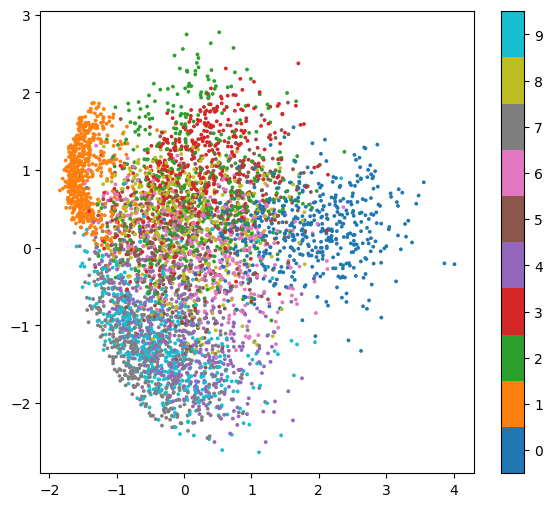

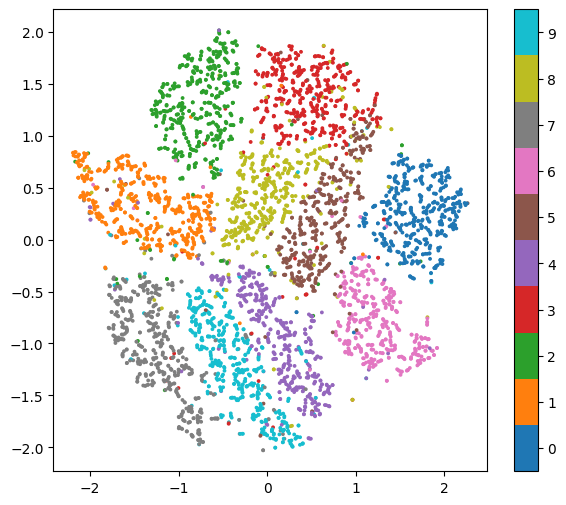

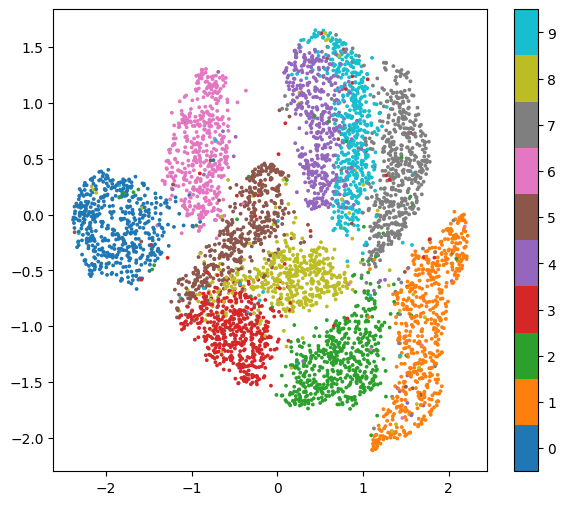

In [4]:
mapper = PCA(n_components=2, whiten=True)
proj_pca = mapper.fit_transform(data_train)
plot(proj_pca, labels_train)

#perplexity: effective number of nearest neighbors. [5,50]
#learning_rate: [10,1000]
mapper = TSNE(perplexity=7, learning_rate='auto')
proj_tsne = mapper.fit_transform(data_train)
proj_tsne = data_util.normalize(proj_tsne)
plot(proj_tsne, labels_train)

#n_neighbors: neighborhood to use
#min_dist: minimum distance
mapper = umap.UMAP(n_neighbors=10, min_dist=0.5)
proj_umap = mapper.fit_transform(data_train)
proj_umap = data_util.normalize(proj_umap)
plot(proj_umap, labels_train)

We fit a logistic regression to the t-SNE data, and plot the decision boundaries:

Accuracy: 89.8
Cross entropy: 0.7007476030419083


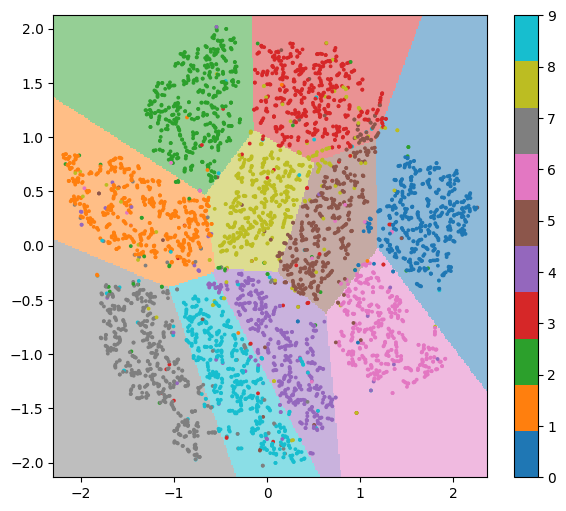

In [5]:
logreg = LogisticRegression(C=1000)
#knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
logreg.fit(proj_tsne, labels_train)
print('Accuracy:', 100*logreg.score(proj_tsne, labels_train))
print('Cross entropy:', cross_entropy(logreg, proj_tsne, labels_train))
viz.plot_regions(logreg.predict, proj_tsne, labels_train)

### Plotting class scores

Instead of plotting the decision boundaries, let's plot the class scores (logits) and class probabilities (softmax applied to the scores).

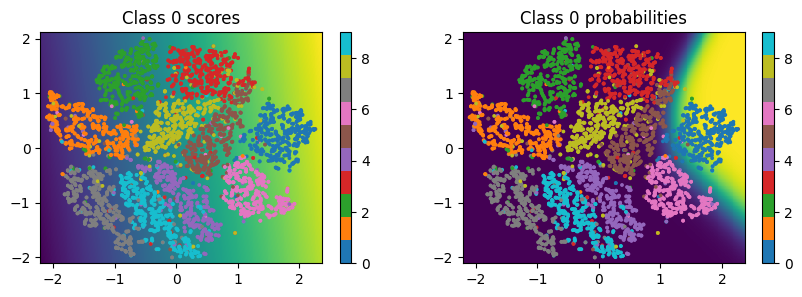

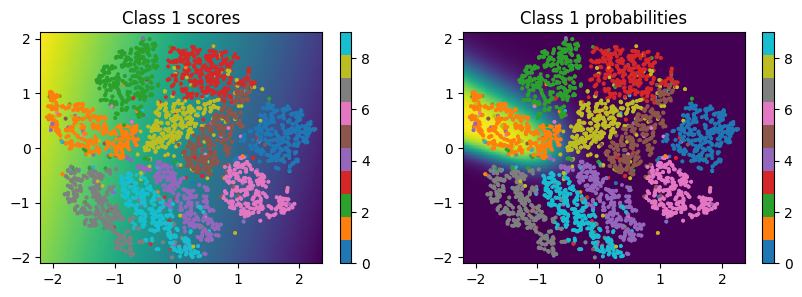

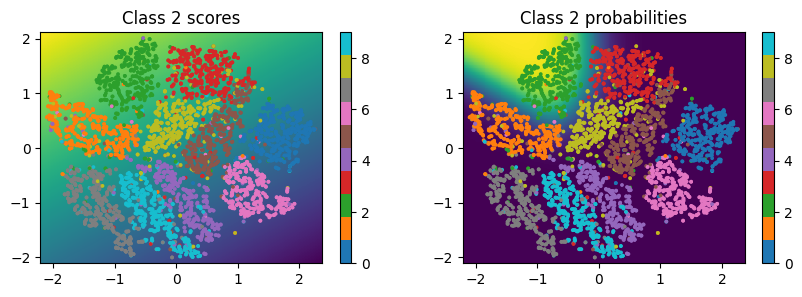

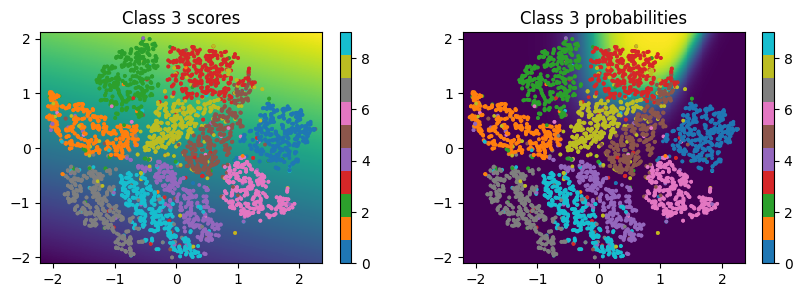

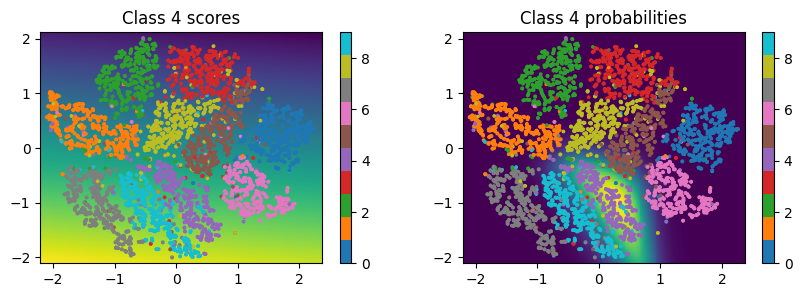

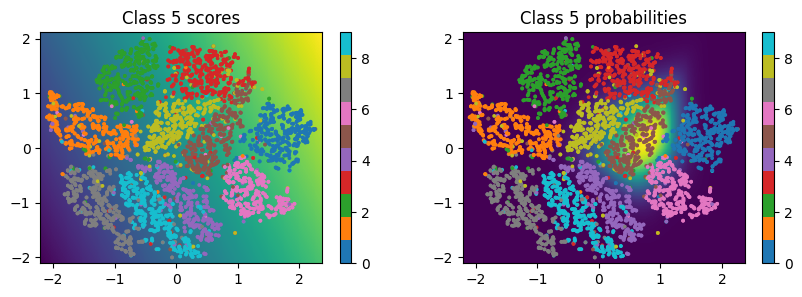

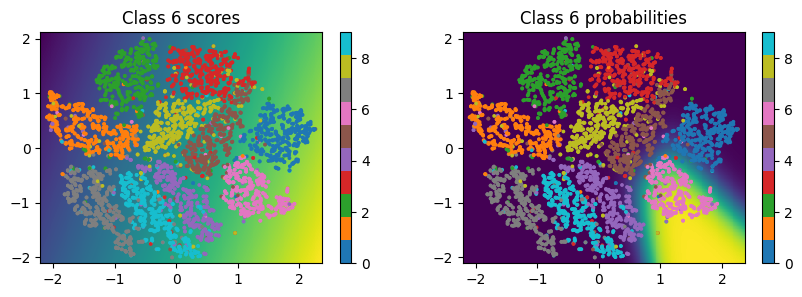

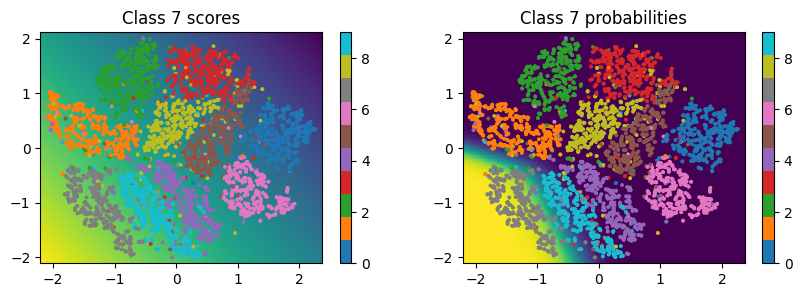

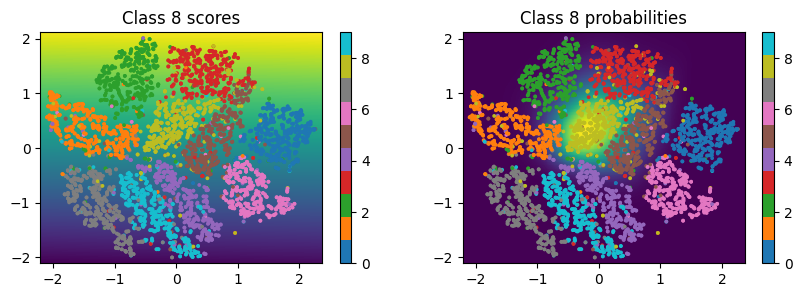

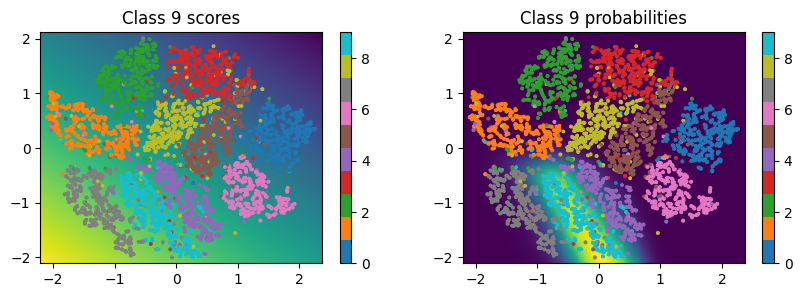

In [4]:
from functools import partial

class Model:
    '''Linear model'''

    def __init__(self, logreg):
    
        self.weights = logreg.coef_
        self.bias = logreg.intercept_

    def __call__(self, x):
        return x@self.weights.T + self.bias
    
def scores(data, model, c):
    logits = model(data)
    return logits[:,c]

def probs(data, model, c):
    logits = model(data)
    probs = scipy.special.softmax(logits, axis=1)
    return probs[:,c]

def plot_scores(model, data, labels_train):

    for c in range(10):

        scores_c = partial(scores, model=model, c=c)
        probs_c = partial(probs, model=model, c=c)

        response, xx0, xx1 = viz.create_image(scores_c, data)

        fig, axes = plt.subplots(1, 2, figsize=(10,3))
        co = axes[0].pcolormesh(xx0, xx1, response)
        sc = axes[0].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[0])
        axes[0].set_title(f'Class {c} scores')

        response, xx0, xx1 = viz.create_image(probs_c, data)

        co = axes[1].pcolormesh(xx0, xx1, response)
        sc = axes[1].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[1])
        axes[1].set_title(f'Class {c} probabilities')

model = Model(logreg)
plot_scores(model, proj_tsne, labels_train)

### Scores and probabilities between class 9 and the others

Let's plot the scores between class 9 and the others. This is roughly equivalent to fitting the logistic model to each pair of classes.

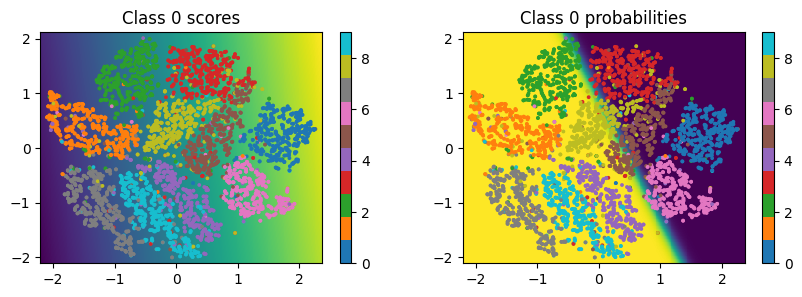

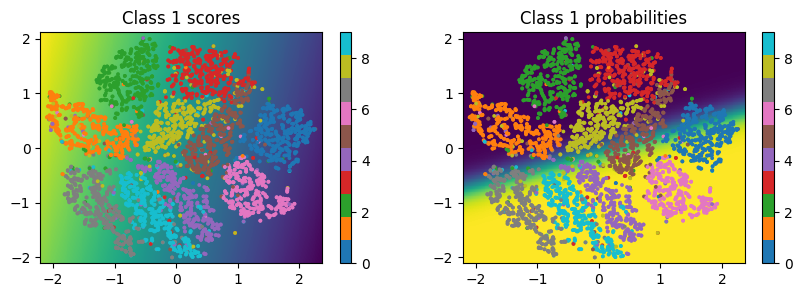

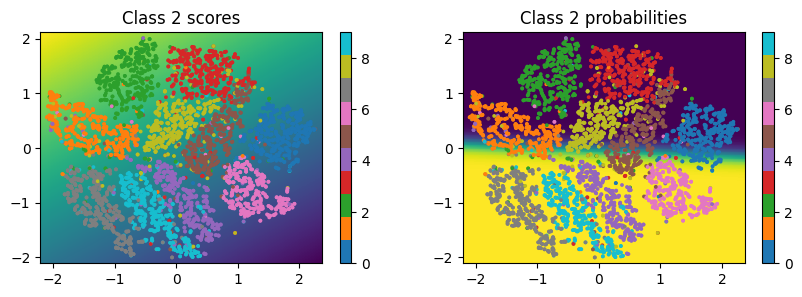

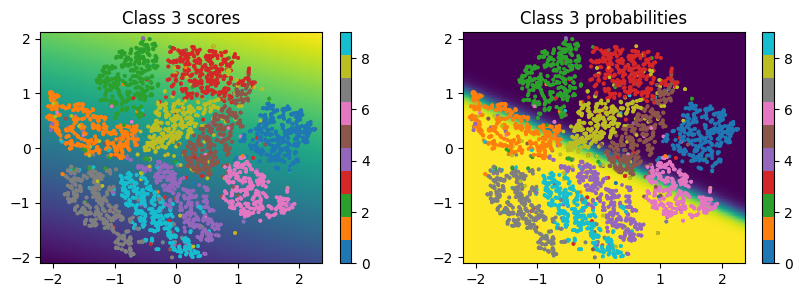

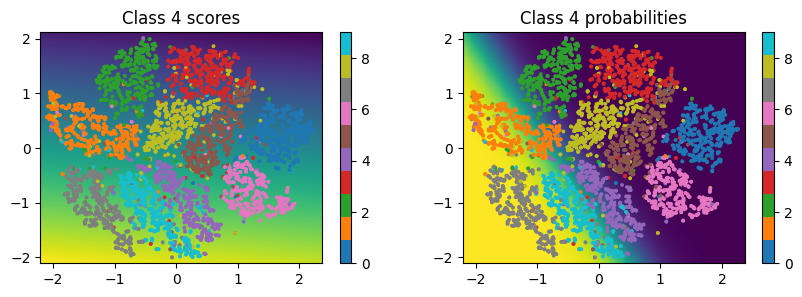

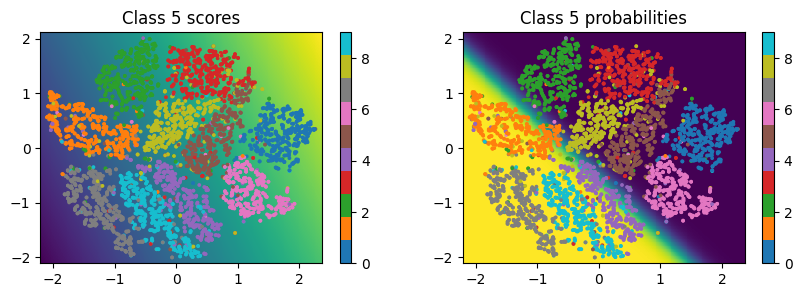

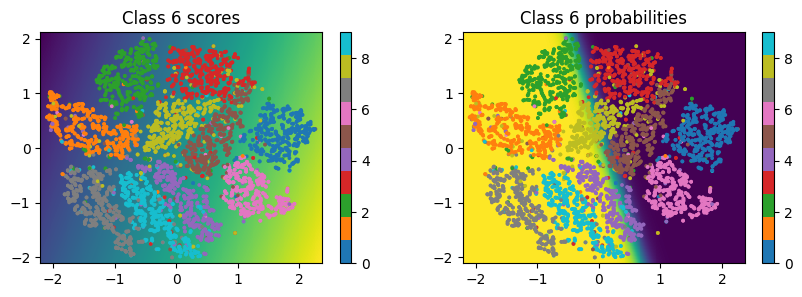

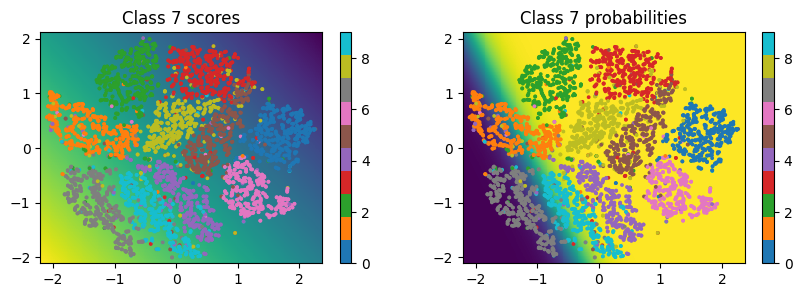

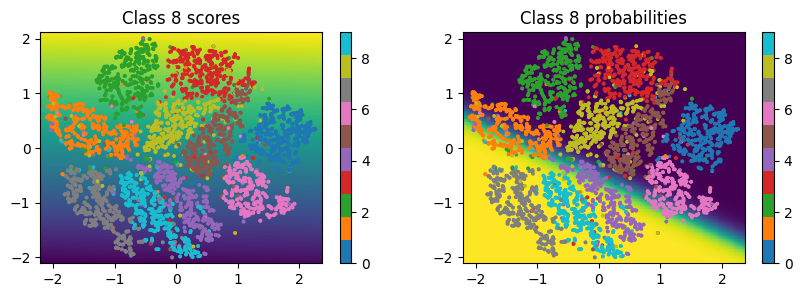

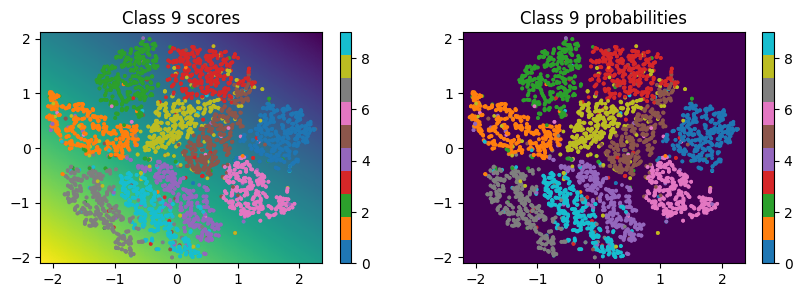

In [5]:
def probs_2_class(data, model, c1, c2):
    logits = model(data)
    logits = logits[:,[c1, c2]]
    probs = scipy.special.softmax(logits, axis=1)
    return probs[:,0]

def plot_scores_2_class(model, data, labels_train, ref_class):

    for c in range(10):

        scores_c = partial(scores, model=model, c=c)
        probs_c = partial(probs_2_class, model=model, c1=ref_class, c2=c)

        response, xx0, xx1 = viz.create_image(scores_c, data)

        fig, axes = plt.subplots(1, 2, figsize=(10,3))
        co = axes[0].pcolormesh(xx0, xx1, response)
        sc = axes[0].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[0])
        axes[0].set_title(f'Class {c} scores')

        response, xx0, xx1 = viz.create_image(probs_c, data)

        co = axes[1].pcolormesh(xx0, xx1, response)
        sc = axes[1].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[1])
        axes[1].set_title(f'Class {c} probabilities')

model = Model(logreg)
plot_scores_2_class(model, proj_tsne, labels_train, ref_class=9)

### Linear separability of the projections

Measure the accuracy of the PCA, t-SNE and UMAP projections

In [6]:
logreg = LogisticRegression(C=1000)
logreg.fit(proj_tsne, labels_train)
print('Accuracy:', 100*logreg.score(proj_tsne, labels_train))
print('Cross entropy:', cross_entropy(logreg, proj_tsne, labels_train))

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(data_train, labels_train)
print('\nTrain loss:', cross_entropy(logreg, data_train, labels_train))
print('Valid loss:', cross_entropy(logreg, data_valid, labels_valid))
print('Train accuracy:', logreg.score(data_train, labels_train))
print('Valid accuracy:', logreg.score(data_valid, labels_valid))

# Using PCA data
logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(data_train_pca, labels_train)
print('\nTrain loss:', cross_entropy(logreg, data_train_pca, labels_train))
print('Valid loss:', cross_entropy(logreg, data_valid_pca, labels_valid))
print('Train accuracy:', logreg.score(data_train_pca, labels_train))
print('Valid accuracy:', logreg.score(data_valid_pca, labels_valid))

Accuracy: 89.68
Cross entropy: 0.7018914815086961

Train loss: 0.0931588212526424
Valid loss: 0.3601530403868394
Train accuracy: 0.9844
Valid accuracy: 0.8985

Train loss: 0.20876900434815307
Valid loss: 0.32071994774886536
Train accuracy: 0.9482
Valid accuracy: 0.9074
